In [1]:
from torchsummary                    import summary
from datetime                        import datetime
from src.data.to_tensor              import ToTensor
from src.data.mrw_dataset            import MRWDataset
from src.data.create_data_loaders    import create_data_loaders
from src.nn.archs                    import Wav2Vec2
from src.nn.training.utils           import Trainer
from src.nn.losses.weighted_mse_loss import WeightedMSELoss
from src.nn.results.utils            import plot_losses

import random
import torch
import torch.nn           as nn
import numpy              as np
import src.ctes.str_ctes  as sctes
import src.ctes.num_ctes  as nctes
import src.ctes.path_ctes as pctes

In [2]:
builder = Wav2Vec2
labels  = sctes.ALL_LABELS

In [3]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device ' + str(device))

Using device cuda


In [5]:
sample_size = nctes.LEN_SAMPLE
dropout_probs=[]
model = builder(n_labels=len(labels))
model.to(device=device)

summary(model, input_size=(1, sample_size))

Layer (type:depth-idx)                                       Param #
├─Wav2Vec2Model: 1-1                                         --
|    └─FeatureExtractor: 2-1                                 --
|    |    └─ModuleList: 3-1                                  (4,200,448)
|    └─Encoder: 2-2                                          --
|    |    └─FeatureProjection: 3-2                           (395,008)
|    |    └─Transformer: 3-3                                 (89,775,488)
|    └─Linear: 2-3                                           (22,301)
├─Wav2Vec2Head: 1-2                                          --
|    └─Sequential: 2-4                                       --
|    |    └─Conv2d: 3-4                                      864
|    |    └─BatchNorm2d: 3-5                                 16
|    |    └─ReLU: 3-6                                        --
|    |    └─Conv2d: 3-7                                      288
|    |    └─BatchNorm2d: 3-8                                 8
| 

Layer (type:depth-idx)                                       Param #
├─Wav2Vec2Model: 1-1                                         --
|    └─FeatureExtractor: 2-1                                 --
|    |    └─ModuleList: 3-1                                  (4,200,448)
|    └─Encoder: 2-2                                          --
|    |    └─FeatureProjection: 3-2                           (395,008)
|    |    └─Transformer: 3-3                                 (89,775,488)
|    └─Linear: 2-3                                           (22,301)
├─Wav2Vec2Head: 1-2                                          --
|    └─Sequential: 2-4                                       --
|    |    └─Conv2d: 3-4                                      864
|    |    └─BatchNorm2d: 3-5                                 16
|    |    └─ReLU: 3-6                                        --
|    |    └─Conv2d: 3-7                                      288
|    |    └─BatchNorm2d: 3-8                                 8
| 

In [6]:
data_path = pctes.DATAPATH
transform = ToTensor()

data = MRWDataset(data_path, transform, sample_size, labels)

In [7]:
batch_size = 8
valid_size = 0.2
test_size = 0.2

train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, test_size, data)

In [8]:
criterion = nn.MSELoss()
print(criterion)

MSELoss()


In [9]:
model_name = "wav2vec test" # name given to the trained model

In [10]:
params = model.parameters()
lr = 0.001
optimizer = torch.optim.Adam(params, lr)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [11]:
n_epochs = 2

In [12]:
timestamp = datetime.now().strftime('%Y_%m_%d__%H_%M_%S')
arch_name  = builder.__name__
hyperparams_path = f"../../../data/models/hyperparams_{arch_name}_{timestamp}.npz"
model_path = f"../../../data/models/model_{arch_name}_{timestamp}"
losses_path = f"../../../data/models/losses_{arch_name}_{timestamp}.npz"

In [13]:
print(timestamp)
print(arch_name)

2024_03_04__18_09_59
Wav2Vec2


In [14]:
np.savez(hyperparams_path, 
         len           = len(data), 
         test_size     = test_size, 
         valid_size    = valid_size, 
         epochs        = n_epochs, 
         batch_size    = batch_size, 
         criterion     = str(criterion), 
         optimizer     = str(optimizer), 
         lr            = lr,
         seed          = seed,
        #  weight_decay  = weight_decay, 
         dropout_probs = dropout_probs, 
         model_name    = model_name,
         arch_name     = arch_name,
         labels        = labels)

In [15]:
train_losses, valid_losses = Trainer.train(n_epochs, train_loader, valid_loader, model, criterion, optimizer, device, model_path, losses_path)

Epoch 1/2 ...
Training ...


  0%|          | 0/1024 [00:00<?, ?it/s]

100%|██████████| 1024/1024 [01:14<00:00, 13.80it/s]


Validating ...


100%|██████████| 256/256 [00:16<00:00, 15.74it/s]


Epoch: 1 	training Loss: 0.108687 	validation Loss: 0.092714
Saving last model ...
Validation loss decreased (inf --> 0.092714).  Saving best model too ...
Saving loss ...
Epoch 2/2 ...
Training ...


100%|██████████| 1024/1024 [01:14<00:00, 13.79it/s]


Validating ...


100%|██████████| 256/256 [00:16<00:00, 15.71it/s]


Epoch: 2 	training Loss: 0.096516 	validation Loss: 0.097765
Saving last model ...
Saving loss ...


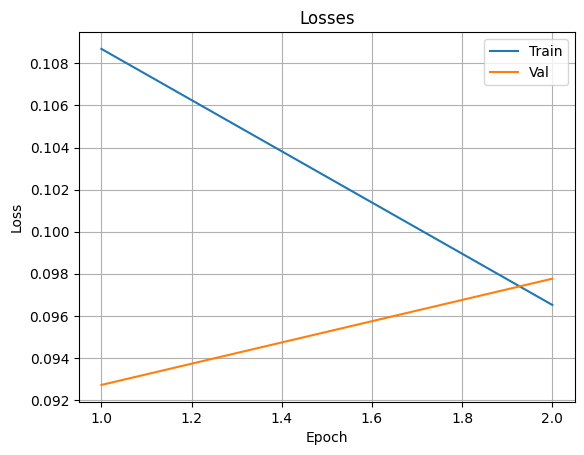

In [16]:
plot_losses(len(train_losses), [train_losses, valid_losses], ["Train", "Val"])